# Landscape change plots

In [1]:
!make -C .. agglomeration_extracts

make: Entering directory '/home/martibosch/data-science/swiss-urbanization'
make: Nothing to be done for 'agglomeration_extracts'.
make: Leaving directory '/home/martibosch/data-science/swiss-urbanization'


In [2]:
import tempfile
from os import path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pylandstats as pls
import rasterio as rio
import seaborn as sns
import swisslandstats as sls
from matplotlib import collections, colors, patches
from mpl_toolkits.basemap import Basemap
from rasterio import transform, warp
from shapely import geometry
from slugify import slugify

from swiss_urbanization import settings

In [3]:
agglom_slugs = ['bern', 'lausanne', 'zurich']

urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

# for Basemap
epsg = 4326
plot_crs = {'init': f'epsg:{epsg}'}
# plot_crs = 'epsg:4326'

In [4]:
agglom_dict = {}
bounds_dict = {}
for agglom_slug in agglom_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglom_slug}.csv')
    landscapes = []
    dates = []
    # TODO: rebase as heat-tail design pattern to avoid calling
    # `calculate_default_transform` repeatedly
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        with tempfile.TemporaryDirectory() as tmpdirname:
            src_fp = path.join(tmpdirname, 'src')
            dst_fp = path.join(tmpdirname, 'dst')
            ldf.to_geotiff(src_fp, urban_nonurban_column, nodata=nodata)
            with rio.open(src_fp) as src:
                transf, width, height = warp.calculate_default_transform(
                    src.crs, plot_crs, src.width, src.height, *src.bounds)
                kwargs = src.meta.copy()
                kwargs.update({
                    'crs': plot_crs,
                    'transform': transf,
                    'width': width,
                    'height': height
                })
                with rio.open(dst_fp, 'w', **kwargs) as dst:
                    warp.reproject(source=rio.band(src, 1),
                                   destination=rio.band(dst, 1),
                                   src_transform=src.transform,
                                   src_crs=src.crs,
                                   dst_transform=transf,
                                   dst_crs=plot_crs)
                    if agglom_slug not in bounds_dict:
                        bounds_dict[agglom_slug] = dst.bounds
            landscapes.append(pls.Landscape(dst_fp))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(ldf['FJ' +
                         urban_nonurban_column[2:4]].value_counts().index[0])
    agglom_dict[agglom_slug] = pls.SpatioTemporalAnalysis(landscapes,
                                                          dates=dates)

In [5]:
min_width = 0
min_height = 0

for agglom_slug in agglom_slugs:
    west, south, east, north = bounds_dict[agglom_slug]
    width = east - west
    if width > min_width:
        min_width = width
    height = north - south
    if height > min_height:
        min_height = height

/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.7/site-packages/owslib/map/wms111.py:121: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.7/site-packages/owslib/map/wms111.py:121: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


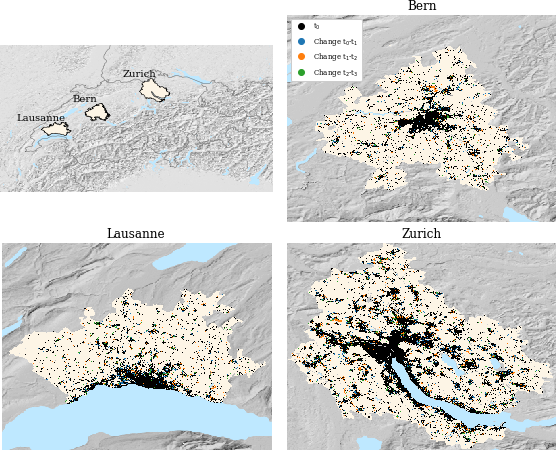

In [8]:
num_cols = 2
num_aggloms = len(agglom_slugs)
num_rows = num_aggloms // num_cols
if num_aggloms % num_cols > 0:
    num_rows += 1

# plt.rcParams['axes.edgecolor'] = (0,0,0,0)
# plt.rcParams['axes.facecolor'] = (0,0,0,0)
agglom_extent_color = colors.to_rgba(colors.cnames['oldlace'], alpha=1)
base_cmap = colors.LinearSegmentedColormap.from_list(
    'binaryalpha', [(0, 0, 0, 0), (0, 0, 0, 1), agglom_extent_color], 3)

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']
fig, axes = plt.subplots(num_rows,
                         num_cols,
                         figsize=(num_rows * 5, num_cols * figheight))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
axes_flat = axes.flat

# place a map of Switzerland with the location of the agglomeration in the first axis
ax = next(axes_flat)
ax.axis('off')

swiss_geom = ox.gdf_from_place('Switzerland').to_crs(
    plot_crs)['geometry'].iloc[0]
west, south, east, north = swiss_geom.bounds
delta_x, delta_y = .5, .5
brightness_inc = .1
swiss_m = Basemap(epsg=epsg,
                  llcrnrlon=west - delta_x,
                  llcrnrlat=south - delta_y,
                  urcrnrlon=east + delta_x,
                  urcrnrlat=north + delta_y,
                  resolution='h',
                  ax=ax)
img = swiss_m.wmsimage(
    'https://image.discomap.eea.europa.eu/arcgis/services/Elevation/'
    'Hillshade/MapServer/WmsServer?',
    layers=['Image'])
grayscale_img = img.get_array().dot([.07, .72, .21])
lim = 1 - brightness_inc
grayscale_img[grayscale_img > lim] = 1
grayscale_img[grayscale_img <= lim] += brightness_inc
img.set_array(grayscale_img)
img.set_cmap('gray')
ax._sci(img)
swiss_m.wmsimage('https://wms.geo.admin.ch/?',
                 layers=['ch.bafu.gefahren-basiskarte.lakes'],
                 transparent=True)
swiss_m.drawcountries(color='dimgray')

gdf = gpd.read_file('../data/raw/gmb/g1a18.shp').to_crs({'init': 'epsg:4326'})
agglom_patches = []
for agglom_slug in agglom_dict:
    agglom_geom = gdf[gdf['ANAME'].apply(slugify).str.contains(
        agglom_slug)]['geometry'].unary_union
    if isinstance(agglom_geom, geometry.MultiPolygon):
        coords = []
        for geom in list(agglom_geom):
            coords += list(zip(*geom.exterior.coords.xy))
    else:
        coords = list(zip(*agglom_geom.exterior.coords.xy))
    # x, y = zip(*coords)
    # swiss_m.plot(x, y, color=agglom_extent_color)
    agglom_patches.append(patches.Polygon(np.array(coords), True))
    ax.add_collection(
        collections.PatchCollection(agglom_patches,
                                    edgecolor='k',
                                    facecolor=agglom_extent_color,
                                    linewidths=.5))
    x, y = zip(*coords)
    ax.annotate(agglom_slug.capitalize(),
                xy=swiss_m(min(x), max(y)),
                ha='center',
                va='bottom')  #  xytext=(0, 5), textcoords='offset points'

# add agglomeration plots in the remaining axes
# for agglomeration extents
delta_x = 0  # 0.01
delta_y = 0  # 0.01
for agglom_slug in agglom_slugs:
    ax = next(axes_flat)
    ax.axis('off')
    ax.set_title(agglom_slug.capitalize())

    landscapes = agglom_dict[agglom_slug].landscapes
    landscape_arr = landscapes[0].landscape_arr
    landscape_height, landscape_width = landscape_arr.shape
    west, south, east, north = bounds_dict[agglom_slug]

    horizontal_margin = (min_width - (east - west)) / 2 + delta_x
    vertical_margin = (min_height - (north - south)) / 2 + delta_y
    _west = west - horizontal_margin
    _south = south - vertical_margin
    _east = east + horizontal_margin
    _north = north + vertical_margin

    m = Basemap(epsg=epsg,
                llcrnrlon=_west,
                llcrnrlat=_south,
                urcrnrlon=_east,
                urcrnrlat=_north,
                ax=ax)
    img = m.wmsimage(
        'https://image.discomap.eea.europa.eu/arcgis/services/Elevation/'
        'Hillshade/MapServer/WmsServer?',
        layers=['Image'])
    img.set_array(img.get_array().dot([.07, .72, .21]))
    img.set_cmap('gray')
    ax._sci(img)
    m.wmsimage('https://wms.geo.admin.ch/?',
               layers=['ch.bafu.gefahren-basiskarte.lakes'],
               transparent=True)

    row_start, col_start = transform.rowcol(
        transform.from_origin(_west, _north, (east - west) / landscape_width,
                              (north - south) / landscape_height), west, north)
    plt_arr = np.zeros(
        (landscape_height + 2 * row_start, landscape_width + 2 * col_start),
        dtype=np.uint8)
    landscape_slices = slice(row_start, row_start + landscape_height), slice(
        col_start, col_start + landscape_width)
    plt_arr[landscape_slices] = landscape_arr
    m.imshow(plt_arr, cmap=base_cmap, origin='upper', ax=ax)

    color_palette_iter = iter(sns.color_palette())
    for i in range(len(landscapes) - 1):
        change_arr = (landscapes[i + 1].landscape_arr == urban_class) & (
            landscapes[i].landscape_arr != urban_class)
        plt_arr = np.zeros_like(plt_arr)
        plt_arr[landscape_slices] = change_arr
        r, g, b = next(color_palette_iter)
        m.imshow(plt_arr,
                 cmap=colors.LinearSegmentedColormap.from_list(
                     i, [(0, 0, 0, 0), (r, g, b, 1)], 2),
                 origin='upper',
                 ax=ax)

# generate a legend and place it in the first agglomeration axis
ax = axes[0][1]
# ax.plot(0, 0, 'o', c=agglom_extent_color, label='Agglomeration extent')
ax.plot(0, 0, 'o', c=(0, 0, 0), label=f't$_0$')
color_palette_iter = iter(sns.color_palette())
for i in range(len(landscapes[:-1])):
    r, g, b = next(color_palette_iter)
    ax.plot(0, 0, 'o', c=(r, g, b), label=f'Change t$_{i}$-t$_{i+1}$')
ax.legend(facecolor='white', framealpha=1, fontsize=7, loc='upper left')

fig.savefig('../reports/figures/landscape_plots.eps')